### ***ETL WITH PAKWHEEL***

In [35]:
import re
import csv
import time
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter, Retry

BASE = "https://www.pakwheels.com"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9"
}

session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=(429, 500, 503))
session.mount("https://", HTTPAdapter(max_retries=retries))

PRICE_RE = re.compile(r"(Rs\.?|PKR|Rs)\s*[\d,]+")
KM_RE = re.compile(r"([\d,]+)\s*(km|KM|Kms|kilometres)", re.I)
YEAR_RE = re.compile(r"\b(19\d{2}|20\d{2})\b")

def fetch(url):
    r = session.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return r.text

def find_containers(soup):
    anchors = soup.find_all("a", href=re.compile(r"^/used-cars/[^/]+/"))
    containers = []

    for a in anchors:
        parent = a
        for _ in range(5):
            if parent is None:
                break
            if parent.name in ("div", "li", "article"):
                if parent.find("img") or PRICE_RE.search(parent.get_text(" ", strip=True)):
                    containers.append(parent)
                    break
            parent = parent.parent

    unique = []
    seen = set()
    for c in containers:
        key = str(c)[:250]
        if key not in seen:
            unique.append(c)
            seen.add(key)
    return unique

def extract(container):
    text = container.get_text(" ", strip=True)

    tag = container.find(["h1","h2","h3","h4"])
    title = tag.get_text(strip=True) if tag else None

    alink = container.find("a", href=re.compile(r"^/used-cars/"))
    url = urljoin(BASE, alink["href"]) if alink else None

    price = None
    for cls in ("price","car-price","ad-price","booking-price"):
        node = container.find(class_=re.compile(cls, re.I))
        if node:
            price = node.get_text(strip=True)
            break
    if not price:
        m = PRICE_RE.search(text)
        if m:
            price = m.group(0)

    year = None
    m = YEAR_RE.search(text)
    if m:
        year = m.group(0)

    km = None
    m = KM_RE.search(text)
    if m:
        km = m.group(0)

    transmission = None
    fuel = None
    location = None

    for meta in container.find_all(["li","span","div"]):
        t = meta.get_text(" ", strip=True)

        if not transmission and re.search(r"Automatic|Manual|AT|MT", t, re.I):
            transmission = re.search(r"Automatic|Manual|AT|MT", t, re.I).group(0)

        if not fuel and re.search(r"Petrol|Diesel|CNG|Hybrid|Electric", t, re.I):
            fuel = re.search(r"Petrol|Diesel|CNG|Hybrid|Electric", t, re.I).group(0)

        for c in ["Karachi","Lahore","Islamabad","Rawalpindi","Peshawar","Multan","Faisalabad","Sialkot","Quetta","Gujranwala"]:
            if c in t:
                location = c

    return {
        "title": title,
        "price": price,
        "year": year,
        "mileage": km,
        "transmission": transmission,
        "fuel": fuel,
        "location": location,
        "url": url
    }

def scrape_10_pages():
    all_rows = []
    for page in range(1, 11):
        url = f"https://www.pakwheels.com/used-cars/search/-/?page={page}"
        print(f"[SCRAPING] Page {page}: {url}")

        html = fetch(url)
        soup = BeautifulSoup(html, "lxml")
        containers = find_containers(soup)

        print(f"[FOUND] {len(containers)} listings")

        for c in containers:
            row = extract(c)
            if row["url"]:
                all_rows.append(row)

        time.sleep(1)

    return all_rows

if __name__ == "__main__":
    rows = scrape_10_pages()

    file = "RAWpakwheel.csv"
    keys = ["title","price","year","mileage","transmission","fuel","location","url"]

    with open(file, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=keys)
        w.writeheader()
        for r in rows:
            w.writerow(r)

    print(f"\n[SAVED] {len(rows)} rows → {file}")

[SCRAPING] Page 1: https://www.pakwheels.com/used-cars/search/-/?page=1
[FOUND] 3 listings
[SCRAPING] Page 2: https://www.pakwheels.com/used-cars/search/-/?page=2
[FOUND] 3 listings
[SCRAPING] Page 3: https://www.pakwheels.com/used-cars/search/-/?page=3
[FOUND] 3 listings
[SCRAPING] Page 4: https://www.pakwheels.com/used-cars/search/-/?page=4
[FOUND] 3 listings
[SCRAPING] Page 5: https://www.pakwheels.com/used-cars/search/-/?page=5
[FOUND] 3 listings
[SCRAPING] Page 6: https://www.pakwheels.com/used-cars/search/-/?page=6
[FOUND] 3 listings
[SCRAPING] Page 7: https://www.pakwheels.com/used-cars/search/-/?page=7
[FOUND] 3 listings
[SCRAPING] Page 8: https://www.pakwheels.com/used-cars/search/-/?page=8
[FOUND] 3 listings
[SCRAPING] Page 9: https://www.pakwheels.com/used-cars/search/-/?page=9
[FOUND] 3 listings
[SCRAPING] Page 10: https://www.pakwheels.com/used-cars/search/-/?page=10
[FOUND] 3 listings

[SAVED] 30 rows → RAWpakwheel.csv


### ***Transformation Block By Pandas & Numpy***

In [21]:
import pandas as pd

df = pd.read_csv("RAWpakwheel.csv")
df.head(50)


,title,price,year,mileage,transmission,fuel,location,url
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.pakwheels.com/used-cars/pakwheels-...
1,Toyota C-HR 2018,"PKR 8,000,000",2018.0,NaN,At,NaN,Karachi,https://www.pakwheels.com/used-cars/search/-/d...
2,Suzuki Mehran 2017 VXR Euro II for Sale,Suzuki Mehran 2017 VXR Euro II for Sale5.1/10...,2017.0,"22,493 km",Manual,Petrol,Lahore,https://www.pakwheels.com/used-cars/suzuki-meh...
3,Toyota C-HR 2018,"PKR 8,000,000",2018.0,NaN,At,NaN,Karachi,https://www.pakwheels.com/used-cars/search/-/d...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.pakwheels.com/used-cars/pakwheels-...
5,Daihatsu Mira 2023 X for Sale,Daihatsu Mira 2023 X for Sale8.5/10PKR 34lacs,2023.0,"19,455 km",Automatic,Petrol,Rawalpindi,https://www.pakwheels.com/used-cars/daihatsu-m...
6,Toyota C-HR 2018,"PKR 8,000,000",2018.0,NaN,At,NaN,Karachi,https://www.pakwheels.com/used-cars/search/-/d...
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.pakwheels.com/used-cars/pakwheels-...
8,Nissan Note 2021 e-Power Aura G Leather Editi...,Nissan Note 2021 e-Power Aura G Leather Editi...,2021.0,"44,245 km",Automatic,Hybrid,Lahore,https://www.pakwheels.com/used-cars/nissan-not...
9,Toyota C-HR 2018,"PKR 8,000,000",2018.0,NaN,At,NaN,Karachi,https://www.pakwheels.com/used-cars/search/-/d...


In [11]:
print(df.columns)


Index(['title', 'price', 'year', 'mileage', 'transmission', 'fuel', 'location',
       'url'],
      dtype='object')


In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv("RAWpakwheel.csv")

# --- 1) Remove duplicates
df.drop_duplicates(inplace=True)

# --- 2) Strip spaces in all string columns
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype(str).str.strip()

# --- 3) Clean price (remove PKR, Rs, commas)
df['price'] = (
    df['price']
    .str.replace("PKR", "", regex=False)
    .str.replace("Rs", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.extract(r'(\d+)', expand=False)
)

df['price'] = pd.to_numeric(df['price'], errors='coerce')

# --- 4) Clean year (only keep valid yyyy)
df['year'] = df['year'].astype(str).str.extract(r'(19\d{2}|20\d{2})', expand=False)
df['year'] = pd.to_numeric(df['year'], errors='coerce')


# --- 5) Clean mileage (remove km, commas)
df['mileage'] = (
    df['mileage']
    .str.replace("km", "", regex=False)
    .str.replace("KM", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.extract(r'(\d+)', expand=False)
)

df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

# --- 6) Standardize transmission
df['transmission'] = df['transmission'].str.title()

# --- 7) Standardize fuel types
df['fuel'] = df['fuel'].str.title()

# --- 8) City names cleanup
df['location'] = df['location'].str.title()

# --- 9) Remove rows missing price or year
df = df.dropna(subset=['price', 'year'])

# --- 10) Reset index
df.reset_index(drop=True, inplace=True)

df.head(50)


,title,price,year,mileage,transmission,fuel,location,url
0,Toyota C-HR 2018,8000000.0,2018.0,NaN,At,Nan,Karachi,https://www.pakwheels.com/used-cars/search/-/d...
1,Suzuki Mehran 2017 VXR Euro II for Sale,2017.0,2017.0,22493.0,Manual,Petrol,Lahore,https://www.pakwheels.com/used-cars/suzuki-meh...
2,Daihatsu Mira 2023 X for Sale,2023.0,2023.0,19455.0,Automatic,Petrol,Rawalpindi,https://www.pakwheels.com/used-cars/daihatsu-m...
3,Nissan Note 2021 e-Power Aura G Leather Editi...,2021.0,2021.0,44245.0,Automatic,Hybrid,Lahore,https://www.pakwheels.com/used-cars/nissan-not...
4,Prince Pearl 2024 MT for Sale,2024.0,2024.0,5900.0,Manual,Petrol,Faisalabad,https://www.pakwheels.com/used-cars/prince-pea...
5,Suzuki Swift 2017 RS 1.0 for Sale,2017.0,2017.0,95000.0,Automatic,Petrol,Karachi,https://www.pakwheels.com/used-cars/suzuki-swi...
6,Honda Civic 2021 Oriel 1.8 i-VTEC CVT for Sale,2021.0,2021.0,80000.0,Automatic,Petrol,Rawalpindi,https://www.pakwheels.com/used-cars/honda-civi...
7,Honda Civic Rebirth 2013 VTi 1.8 i-VTEC for Sale,2013.0,2013.0,184922.0,Manual,Petrol,Islamabad,https://www.pakwheels.com/used-cars/honda-civi...
8,Suzuki Every 6th Generation (Imported) 2020 PC...,6.0,2020.0,95500.0,Automatic,Petrol,Lahore,https://www.pakwheels.com/used-cars/suzuki-eve...
9,Mercedes Benz S Class 2006 S350 for Sale,2006.0,2006.0,62000.0,Automatic,Petrol,Lahore,https://www.pakwheels.com/used-cars/mercedes-b...


### ***Transformation By Matplotlib***

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#### Price Distribution

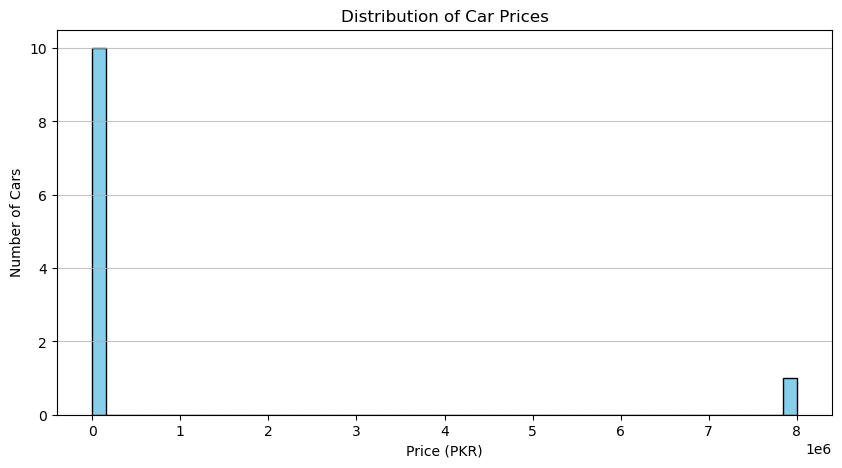

In [24]:
plt.figure(figsize=(10,5))
plt.hist(df['price'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Price (PKR)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Car Prices")
plt.grid(axis='y', alpha=0.75)
plt.show()


#### Mileage Distribution

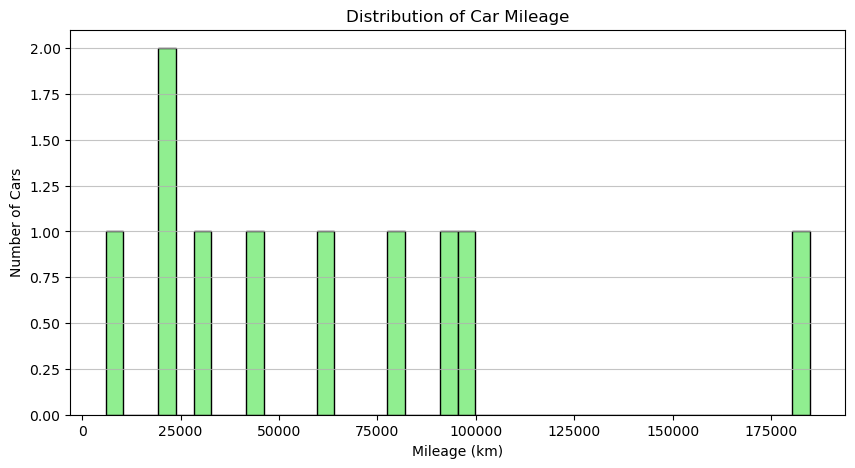

In [25]:
plt.figure(figsize=(10,5))
plt.hist(df['mileage'], bins=40, color='lightgreen', edgecolor='black')
plt.xlabel("Mileage (km)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Car Mileage")
plt.grid(axis='y', alpha=0.75)
plt.show()


#### Year vs Price (Scatter Plot)

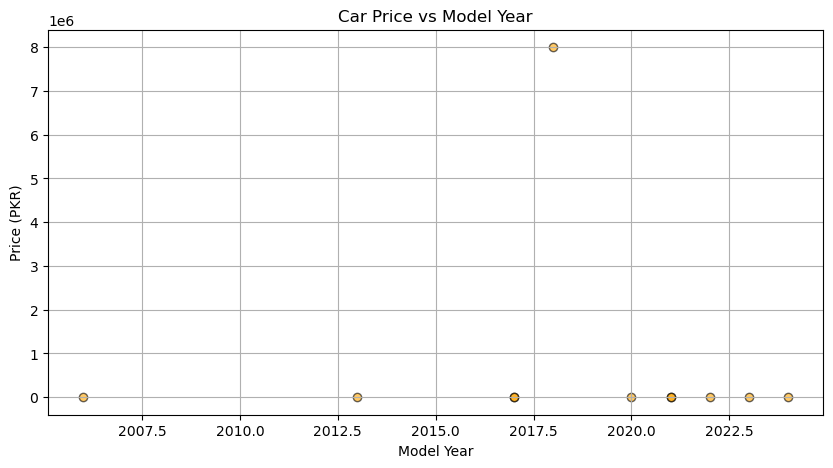

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(df['year'], df['price'], alpha=0.6, color='orange', edgecolor='black')
plt.xlabel("Model Year")
plt.ylabel("Price (PKR)")
plt.title("Car Price vs Model Year")
plt.grid(True)
plt.show()


#### Cities by Listings (Bar Chart)

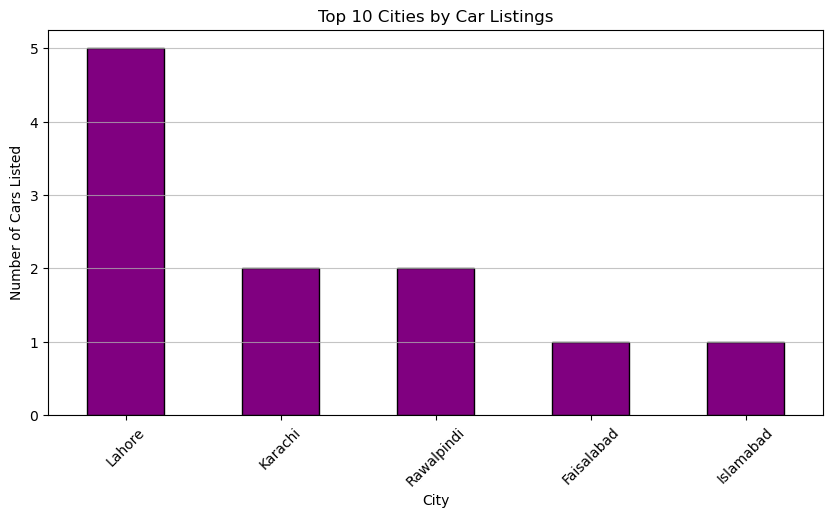

In [27]:
top_cities = df['location'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_cities.plot(kind='bar', color='purple', edgecolor='black')
plt.xlabel("City")
plt.ylabel("Number of Cars Listed")
plt.title("Top 10 Cities by Car Listings")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


#### Average Price per City (Horizontal Bar)

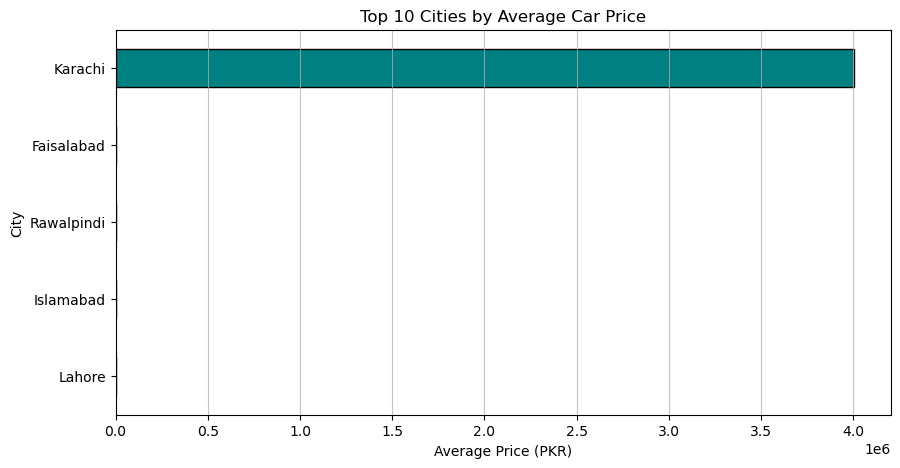

In [28]:
avg_price_city = df.groupby('location')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
avg_price_city.plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel("Average Price (PKR)")
plt.ylabel("City")
plt.title("Top 10 Cities by Average Car Price")
plt.gca().invert_yaxis()  # Highest price top pe
plt.grid(axis='x', alpha=0.75)
plt.show()


#### Mileage vs Price Regression Trend

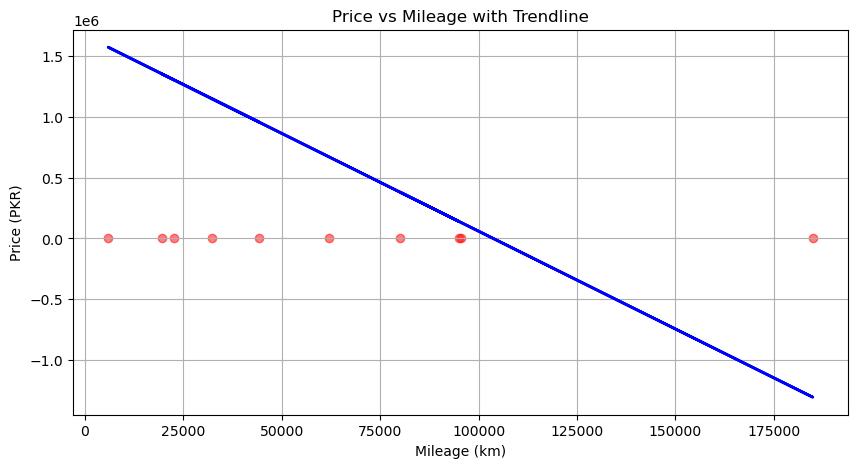

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(df['mileage'], df['price'], alpha=0.5, color='red')
z = np.polyfit(df['mileage'].fillna(0), df['price'].fillna(0), 1)  # linear fit
p = np.poly1d(z)
plt.plot(df['mileage'], p(df['mileage']), color='blue', linewidth=2)
plt.xlabel("Mileage (km)")
plt.ylabel("Price (PKR)")
plt.title("Price vs Mileage with Trendline")
plt.grid(True)
plt.show()


In [31]:
# Save the fully cleaned DataFrame to a new CSV file
df.to_csv("pakwheels_cleaned.csv", index=False, encoding="utf-8")

print(f"✅ Cleaned data saved! Total rows: {len(df)} → pakwheels_cleaned.csv")


✅ Cleaned data saved! Total rows: 11 → pakwheels_cleaned.csv
